## Visualization of CNN: Grad-CAM
* **Objective**: Convolutional Neural Networks are widely used on computer vision. It is powerful for processing grid-like data. However we hardly know how and why it works, due to the lack of decomposability into individually intuitive components. In this assignment, we will introduce the Grad-CAM which visualizes the heatmap of input images by highlighting the important region for visual question answering(VQA) task.

* **To be submitted**: this notebook in two weeks, **cleaned** (i.e. without results, for file size reasons: `menu > kernel > restart and clean`), in a state ready to be executed (if one just presses 'Enter' till the end, one should obtain all the results for all images) with a few comments at the end. No additional report, just the notebook!

* NB: if `PIL` is not installed, try `conda install pillow`.


In [1]:
import torch
import torch.nn.functional as F
import numpy as np

import torchvision.transforms as transforms
from PIL import Image

import cv2

import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Visual Question Answering problem
Given an image and a question in natural language, the model choose the most likely answer from 3 000 classes according to the content of image. The VQA task is indeed a multi-classificaition problem.
<img src="vqa_model.PNG">

We provide you a pretrained model `vqa_resnet` for VQA tasks.

In [2]:
# load model
from load_model import load_model
vqa_resnet = load_model()

In [3]:
print(vqa_resnet.eval()) # for more information 

VQA_Resnet_Model(
  (text): TextProcessor(
    (embedding): Embedding(15193, 300, padding_idx=0)
    (drop): Dropout(p=0.5, inplace=False)
    (tanh): Tanh()
    (lstm): LSTM(300, 1024)
  )
  (attention): Attention(
    (v_conv): Conv2d(2048, 512, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (q_lin): Linear(in_features=1024, out_features=512, bias=True)
    (x_conv): Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1))
    (drop): Dropout(p=0.5, inplace=False)
    (relu): ReLU(inplace=True)
  )
  (classifier): Classifier(
    (drop1): Dropout(p=0.5, inplace=False)
    (lin1): Linear(in_features=5120, out_features=1024, bias=True)
    (relu): ReLU()
    (drop2): Dropout(p=0.5, inplace=False)
    (lin2): Linear(in_features=1024, out_features=3000, bias=True)
  )
  (resnet_layer4): ResNetLayer4(
    (r_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [4]:
checkpoint = '2017-08-04_00.55.19.pth'
saved_state = torch.load(checkpoint, map_location=device)
# reading vocabulary from saved model
vocab = saved_state['vocab']

# reading word tokens from saved model
token_to_index = vocab['question']

# reading answers from saved model
answer_to_index = vocab['answer']

num_tokens = len(token_to_index) + 1

# reading answer classes from the vocabulary
answer_words = ['unk'] * len(answer_to_index)
for w, idx in answer_to_index.items():
    answer_words[idx]=w

### Inputs
In order to use the pretrained model, the input image should be normalized using `mean = [0.485, 0.456, 0.406]`, and `std = [0.229, 0.224, 0.225]`, and be resized as `(448, 448)`. You can call the function `image_to_features` to achieve image preprocessing. For input question, the function `encode_question` is provided to encode the question into a vector of indices. You can also use `preprocess` function for both image and question preprocessing.

In [5]:
def get_transform(target_size, central_fraction=1.0):
    return transforms.Compose([
        transforms.Scale(int(target_size / central_fraction)),
        transforms.CenterCrop(target_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

In [6]:
def encode_question(question):
    """ Turn a question into a vector of indices and a question length """
    question_arr = question.lower().split()
    vec = torch.zeros(len(question_arr), device=device).long()
    for i, token in enumerate(question_arr):
        index = token_to_index.get(token, 0)
        vec[i] = index
    return vec, torch.tensor(len(question_arr), device=device)

In [7]:
# preprocess requires the dir_path of an image and the associated question. 
#It returns the spectific input form which can be used directly by vqa model. 
def preprocess(dir_path, question):
    q, q_len = encode_question(question)
    img = Image.open(dir_path).convert('RGB')
    image_size = 448  # scale image to given size and center
    central_fraction = 1.0
    transform = get_transform(image_size, central_fraction=central_fraction)
    img_transformed = transform(img)
    img_features = img_transformed.unsqueeze(0).to(device)
    
    inputs = (img_features, q.unsqueeze(0), q_len.unsqueeze(0))
    return inputs

We provide you two pictures and some question-answers.

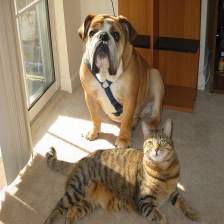

In [8]:
Question1 = 'What animal'
Answer1 = ['dog','cat' ]
indices1 = [answer_to_index[ans] for ans in Answer1]# The indices of category 
img1 = Image.open('dog_cat.png')
img1

In [9]:
dir_path = 'dog_cat.png' 
inputs = preprocess(dir_path, Question1)
ans = vqa_resnet(*inputs) # use model to predict the answer
answer_idx = np.argmax(F.softmax(ans, dim=1).detach().cpu().numpy())
print(answer_words[answer_idx])

dog


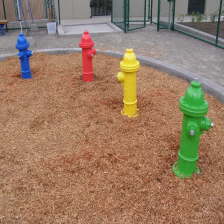

In [10]:
Question2 = 'What color'
Answer2 = ['green','yellow' ]
indices2 = [answer_to_index[ans] for ans in Answer2]
img2 = Image.open('hydrant.png')
img2

In [11]:
dir_path = 'hydrant.png' 
inputs = preprocess(dir_path, Question2)
ans = vqa_resnet(*inputs) # use model to predict the answer
answer_idx = np.argmax(F.softmax(ans, dim=1).data.numpy())
print(answer_words[answer_idx])

green


### Grad-CAM 
* **Overview:** Given an image with a question, and a category (‘dog’) as input, we foward propagate the image through the model to obtain the `raw class scores` before softmax. The gradients are set to zero for all classes except the desired class (dog), which is set to 1. This signal is then backpropagated to the `rectified convolutional feature map` of interest, where we can compute the coarse Grad-CAM localization (blue heatmap).


* **To Do**: Define your own function Grad_CAM to achieve the visualization of the two images. For each image, consider the answers we provided as the desired classes. Compare the heatmaps of different answers, and conclude. 


* **Hints**: 
 + We need to record the output and grad_output of the feature maps to achieve Grad-CAM. In pytorch, the function `Hook` is defined for this purpose. Read the tutorial of [hook](https://pytorch.org/tutorials/beginner/former_torchies/nnft_tutorial.html#forward-and-backward-function-hooks) carefully. 
 + The pretrained model `vqa_resnet` doesn't have the activation function after its last layer, the output is indeed the `raw class scores`, you can use it directly. Run "print(vqa_resnet)" to get more information on VGG model.
 + The last CNN layer of the model is: `vqa_resnet.resnet_layer4.r_model.layer4[2].conv3` 
 + The size of feature maps is 14x14, so as your heatmap. You need to project the heatmap to the original image(224x224) to have a better observation. The function `cv2.resize()` may help.  
 + Here is the link of the paper [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/pdf/1610.02391.pdf)

<img src="grad_cam.png">

In [12]:
class GradCAM:
    def __init__(self, model, feature_layer):
        """Wrapper around a given model to perform GradCAM on its given feature layer.

        It will register hooks on the given layer.  (They can be removed with `clean`)

        Args:
            model (nn.Module): Torch Module
            feature_layer (nn.Module): The sub module of model that correspond to the feature layer
                on which we want to perform grad cam algorithm.
        """
        self.model = model

        # Will register the gradient and activation for the output of the feature_layer
        self.activation = None
        self.gradient = None

        self.handle_forward = feature_layer.register_forward_hook(self._forward_hook)
        self.handle_backward = feature_layer.register_backward_hook(self._backward_hook)

    def _forward_hook(self, layer, input_, output):
        self.activation = output

    def _backward_hook(self, layer, input_, output):
        self.gradient = output[0]

    def __call__(self, *args, target=None, **kwargs):
        """Do a forward backward pass on the model given the output and returns the GradCAM heatmap
        
        By default it will focus back propagate only on the best predicted class.
        You can also precise the targets you are interested in.
        
        Handle different batch sizes, and returns the batch of heatmaps.
        """
        self.model.zero_grad()
        outputs = self.model(*args, **kwargs)
        batch_size = outputs.shape[0]

        if target is None:
            target = torch.argmax(outputs, dim=1)

        results = outputs[range(batch_size), target].sum()
        results.backward()  # Back propagate only the target. (one by prediction)
        
#         print("Targets:", [answer_words[target[i]] for i in range(batch_size)])
#         print(results)

        feature_weights = torch.mean(self.gradient, dim=[2, 3], keepdim=True) # Shape: (batch_size, n_feat, 1, 1)

        weighted_activation = self.activation * feature_weights  # Shape: (batch_size, n_feat, x_feat, y_feat)
        heatmap = torch.functional.F.relu(torch.sum(weighted_activation, dim=1)) # Shape: (batch_size, x_feat, y_feat)

        return heatmap

    def clean(self):
        """Remove the hook added to the layer."""
        self.handle_forward.remove()
        self.handle_backward.remove()

    def __del__(self):
        self.clean()

try:
    grad_cam.clean()
except NameError:
    pass

grad_cam = GradCAM(vqa_resnet, vqa_resnet.resnet_layer4.r_model.layer4[2].conv3)

In [13]:
def Grad_CAM(grad_cam, img_path, question, answer):
    img = np.flip(cv2.imread(img_path), -1)
    plt.imshow(img)
    plt.show()
    inputs = preprocess(img_path, question)
    answer_id = torch.tensor(answer_to_index[answer]).view(1).to(device)
    heatmap = grad_cam(*inputs, target=answer_id)[0].detach().cpu().numpy()
    # Normalize and resize
    if heatmap.max() > 0:
        heatmap /= heatmap.max()
    heatmap = cv2.resize(heatmap, (224, 224))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8((heatmap * 0.4 + img*0.6))
    plt.imshow(superimposed_img)
    plt.show()

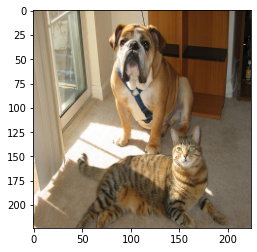

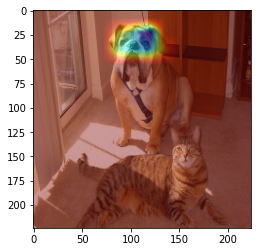

In [14]:
# Let's try to explain the dog answer of the model.

question = 'What animal'
answer = 'dog'
img_path = 'dog_cat.png'
Grad_CAM(grad_cam, img_path, question, answer)

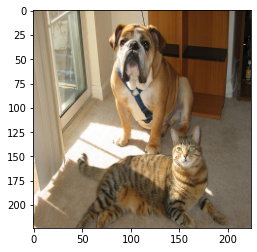

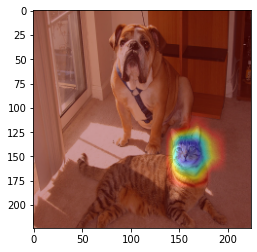

In [15]:
# What if we want to check what triggers the cat logits.

question = 'What animal'
answer = 'cat'
img_path = 'dog_cat.png'
Grad_CAM(grad_cam, img_path, question, answer)

One can see that in both case we are able to build a heatmap on the head of the animal that we are looking for. It works quite well.

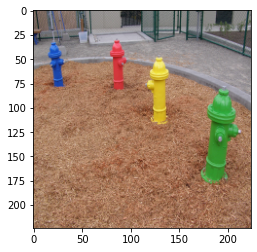

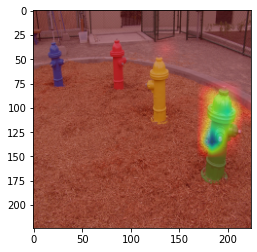

In [16]:
question = 'What color'
answer = 'green'
img_path = 'hydrant.png'
Grad_CAM(grad_cam, img_path, question, answer)

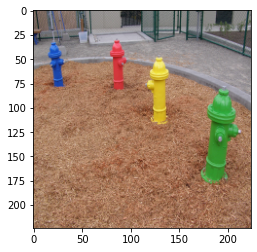

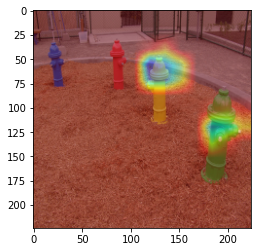

In [17]:
question = 'What color'
answer = 'yellow'
img_path = 'hydrant.png'
Grad_CAM(grad_cam, img_path, question, answer)

In the other hand, even though we have quite good results, we can see that it's not perfect for yellow (and one could also try with red and blue, it's worse!).

Nonetheless it's quite impressive and we could try to build a segmentation or a bounding box from these heatmaps without more data, as describe in the article which could be useful.